In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import kendalltau
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import t
from scipy.stats import jf_skew_t

In [71]:
class CustomMonteCarlo:
    def __init__(self, tickers):
        self.tickers = tickers

    def generate_parameters(self, start, end):
        # Generate parameters for simulation based on historical data, choose your own start and end date
        stockData = yf.download(self.tickers, start=start, end = end, multi_level_index=False, auto_adjust=True).Close
        if isinstance(stockData, pd.Series):
            stockData = stockData.to_frame(name=self.tickers[0])
        if len(self.tickers)==1:
            stockData['Copy'] = stockData.iloc[:]
        else:
            stockData = stockData[self.tickers]
        self.log_returns = np.log(stockData/stockData.shift(1)).dropna()
        self.mean = self.log_returns.mean()
        self.var = self.log_returns.var()
        self.skew = self.log_returns.skew()
        self.covmatrix = self.log_returns.cov()
        self.corr = self.log_returns.corr().iloc[0, 1]
        self.tau, self.pval = kendalltau(self.log_returns.iloc[:, 0], self.log_returns.iloc[:,1]) 
        

    def logNormMC(self, sims, time, initial, interval, weights, rho):
        # Can use histoical correlation or customize (but make sure to use correlation of log returns!)

        sig1, sig2 = np.sqrt(self.var.iloc[0]), np.sqrt(self.var.iloc[1])
        covMatrix = np.array([[self.var.iloc[0], rho*sig1*sig2],
                             [rho*sig1*sig2, self.var.iloc[1]]])
        # Monte Carlo Method
        
        mc_sims = sims
        T = time #timeframe in days
        
        meanM = np.full(shape=(T, len(weights)), fill_value=self.mean)
        meanM = meanM.T
        
        self.norm_portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
        
        initialPortfolio = initial
        interval = interval
        weights = np.array(weights) 
        
        for j in range(0, mc_sims):
            # Generate negatively correlated multivariate normal returns
            Z = np.random.normal(size=(T, len(weights)))
            L = np.linalg.cholesky(covMatrix)
            dailyReturns = meanM + L @ Z.T
            current_port = initialPortfolio * weights

            # Rebalance according to interval
            for i in range(0, T):
                if i >0 and i% interval == 0:
                    current_port = np.sum(current_port) * weights
                current_port = current_port * np.exp(dailyReturns[:,i])
                self.norm_portfolio_sims[i,j] = np.sum(current_port)
        
        self.norm_portfolio_sims = np.vstack([np.full((1, sims), initial), self.norm_portfolio_sims])
        self.norm_results = pd.Series(self.norm_portfolio_sims[-1, :])
        plt.plot(self.norm_portfolio_sims)
        plt.ylabel('Portfolio Value ($)')
        plt.xlabel('Days')
        if len(self.tickers) == 2:
            plt.title(f'MC simulation of Log-Normal stock portfolio ({int(weights[0]*100)}% {self.tickers[0]}, {int(weights[1]*100)}% {self.tickers[1]})')
        else:
            plt.title(f'MC simulation of Log-Normal stock portfolio (100% {self.tickers[0]})')
        plt.show()   

    def skewnormMC(self, sims, time, initial, interval, weights, kendall):

        # Monte Carlo Method 
        mc_sims = sims
        T = time #timeframe in days
        
        self.skewnorm_portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
        interval = interval
        weights = np.array(weights) 

        # Calculate Copula Parameter based on Kendall's Tau
        cop_param = np.sin(np.pi*kendall/2)

        # Generate multivariate normal values
        copula_corr = np.array([[1, cop_param],
                               [cop_param, 1]])

        # Calculate skew-norm distribution parameters
        a1, loc1, scale1 = skewnorm.fit(self.log_returns.iloc[:, 0])
        a2, loc2, scale2 = skewnorm.fit(self.log_returns.iloc[:, 1]) 

        for j in range(0, mc_sims):
            
            Z = np.random.multivariate_normal([0,0], copula_corr, size=(T))
    
            # Convert to uniform with CDF
            U = norm.cdf(Z)
            U1 = U[:,0]
            U2 = U[:,1]                                   
    
            # Convert back to returns with inverse CDF
            R1 = skewnorm.ppf(U1, a=a1, loc=loc1, scale=scale1)
            R2 = skewnorm.ppf(U2, a=a2, loc=loc2, scale=scale2)
            dailyReturns = np.array([R1, R2])
                                    

            current_port = initial * weights
            
            for i in range(0, T):
                if i >0 and i%interval == 0:
                    current_port = np.sum(current_port) * weights
                current_port = current_port * np.exp(dailyReturns[:, i])
                self.skewnorm_portfolio_sims[i,j] = np.sum(current_port)


        self.skewnorm_portfolio_sims = np.vstack([np.full((1, sims), initial), self.skewnorm_portfolio_sims])
        self.skewnorm_results = pd.Series(self.skewnorm_portfolio_sims[-1, :])
        plt.plot(self.skewnorm_portfolio_sims)
        plt.ylabel('Portfolio Value ($)')
        plt.xlabel('Days')
        if len(self.tickers) == 2:
            plt.title(f'MC simulation of Skew-Normal stock portfolio ({int(weights[0]*100)}% {self.tickers[0]}, {int(weights[1]*100)}% {self.tickers[1]})')
        else:
            plt.title(f'MC simulation of Skew-Normal stock portfolio (100% {self.tickers[0]})')
        plt.show()


    def tDistMC(self, sims, time, initial, interval, weights, rho, df):
        # Can use histoical correlation or customize (but make sure to use correlation of log returns!)

        sig1, sig2 = np.sqrt(self.var.iloc[0]), np.sqrt(self.var.iloc[1])
        covMatrix = np.array([[self.var.iloc[0], rho*sig1*sig2],
                             [rho*sig1*sig2, self.var.iloc[1]]])

        nu = df # degrees of freedom 

        scatter = covMatrix * (nu-2)/nu
        
        # Monte Carlo Method
        
        mc_sims = sims
        T = time #timeframe in days
        
        meanM = np.full(shape=(T, len(weights)), fill_value=self.mean)
        meanM = meanM.T
        
        self.t_portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
        
        initialPortfolio = initial
        interval = interval
        weights = np.array(weights) 
        
        for j in range(0, mc_sims):
            # Generate negatively correlated multivariate normal returns
            Z = np.random.normal(size=(T, len(weights)))
            L = np.linalg.cholesky(scatter)
            S = np.random.chisquare(nu, size = T)
            dailyReturns = meanM + (L @ Z.T)*np.sqrt(nu/S)
            current_port = initialPortfolio * weights

            # Rebalance according to interval
            for i in range(0, T):
                if i >0 and i% interval == 0:
                    current_port = np.sum(current_port) * weights
                current_port = current_port * np.exp(dailyReturns[:,i])
                self.t_portfolio_sims[i,j] = np.sum(current_port)
        
        self.t_portfolio_sims = np.vstack([np.full((1, sims), initial), self.t_portfolio_sims])
        self.t_results = pd.Series(self.t_portfolio_sims[-1, :])
        plt.plot(self.t_portfolio_sims)
        plt.ylabel('Portfolio Value ($)')
        plt.xlabel('Days')
        if len(self.tickers) == 2:
            plt.title(f'MC simulation of Student-t stock portfolio ({int(weights[0]*100)}% {self.tickers[0]}, {int(weights[1]*100)}% {self.tickers[1]})')
        else:
            plt.title(f'MC simulation of Student-t stock portfolio (100% {self.tickers[0]})')
        plt.show()


    def skewtMC(self, sims, time, initial, interval, weights, kendall, nu_c):

        # Monte Carlo Method 
        mc_sims = sims
        T = time #timeframe in days
        
        self.skewt_portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
        interval = interval
        weights = np.array(weights) 

        # Calculate Copula Parameter based on Kendall's Tau
        cop_param = np.sin(np.pi*kendall/2)

        # Generate multivariate normal values
        copula_corr = np.array([[1, cop_param],
                               [cop_param, 1]])

        # Calculate skew-t distribution parameters
        a1, b1, mu1, sig1 = jf_skew_t.fit(self.log_returns.iloc[:, 0])
        a2, b2, mu2, sig2 = jf_skew_t.fit(self.log_returns.iloc[:, 1]) 

        # Calculate uniforms (optional step if you want more advanced calculations like copula-likelihood for more specific parameter estimation)
        # U1 and U2 are not directly used for simulation
        U1 = jf_skew_t.cdf(self.log_returns.iloc[:, 0], a1, b1, mu1, sig1)
        U2 = jf_skew_t.cdf(self.log_returns.iloc[:, 1], a2, b2, mu2, sig2)

        for j in range(0, mc_sims):
            
            Z = np.random.multivariate_normal([0,0], copula_corr, size=T)
            S = np.random.chisquare(df=nu_c, size=T)
            W = Z/np.sqrt(S[:, None]/nu_c)
            U = t.cdf(W, df=nu_c)
    
            # Convert back to returns with inverse CDF
            R1 = jf_skew_t.ppf(U[:, 0], a1, b1, mu1, sig1)
            R2 = jf_skew_t.ppf(U[:, 1], a2, b2, mu2, sig2)
            dailyReturns = np.array([R1, R2])
                                    

            current_port = initial * weights
            
            for i in range(0, T):
                if i >0 and i%interval == 0:
                    current_port = np.sum(current_port) * weights
                current_port = current_port * np.exp(dailyReturns[:, i])
                self.skewt_portfolio_sims[i,j] = np.sum(current_port)


        self.skewt_portfolio_sims = np.vstack([np.full((1, sims), initial), self.skewt_portfolio_sims])
        self.skewt_results = pd.Series(self.skewt_portfolio_sims[-1, :])
        plt.plot(self.skewt_portfolio_sims)
        plt.ylabel('Portfolio Value ($)')
        plt.xlabel('Days')
        if len(self.tickers) == 2:
            plt.title(f'MC simulation of Skew-t stock portfolio ({int(weights[0]*100)}% {self.tickers[0]}, {int(weights[1]*100)}% {self.tickers[1]})')
        else:
            plt.title(f'MC simulation of Skew-t stock portfolio (100% {self.tickers[0]})')
        plt.show()
       

    def mcVAR(self, initial, results, alpha):
        """
        Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
        """ 
        if isinstance(results, pd.Series):
            print(f"Value at Risk ({100-alpha}% VaR): {np.round((initial - np.percentile(results, alpha))*100/initial,2)}%")
        else:
            raise TypeError("Expected a pandas data series")

    def mcCTE(self, initial, results, alpha):
        """
        Input: pandas series of returns
        Output: CTE or Expected Shortfall to a given confidence level alpha
        """ 
        if isinstance(results, pd.Series):
            belowVAR = results <= np.percentile(results, alpha)
            print(f"Conditional Tail Expectation ({100-alpha}% CTE): {np.round((initial - results[belowVAR].mean())*100/initial,2)}%")
        else:
            raise TypeError("Expected a pandas data series")
        
    def term_wealth(self, results):
        terminal_wealth = pd.Series(results) # probably need to turn portfolio_sims[-1,:] into a self.
        plt.hist(terminal_wealth, bins=50)
        plt.title('Distribution of Final Portfolio Values')
        plt.show()
        print(f"Median Wealth: ${np.round(terminal_wealth.median(),2)}")

    def max_dd(self, portfolio_sims):
        max_dd_dist = []
        paths = portfolio_sims.T
        for path in paths:
            path = pd.Series(path)
            cummax = path.cummax()
            max_dd = 0
            for i in range(len(path)):
                max_dd = max(((cummax.iloc[i] - path.iloc[i])/cummax.iloc[i]), max_dd)
            max_dd_dist.append(max_dd)

        max_dd_dist = pd.Series(max_dd_dist)
        plt.hist(max_dd_dist)
        plt.title('Distribution of Max Drawdowns')
        plt.show()
        print(f"Median Max Drawdown: {np.round(max_dd_dist.median()*100,2)}%")
        print(f"Worst Max Drawdown: {np.round(max(max_dd_dist)*100,2)}%")


[*********************100%***********************]  2 of 2 completed


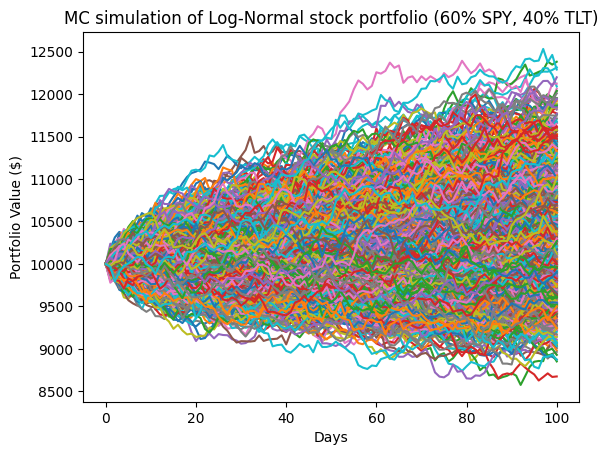

Value at Risk (95% VaR): 6.18%
Conditional Tail Expectation (95% CTE): 8.42%


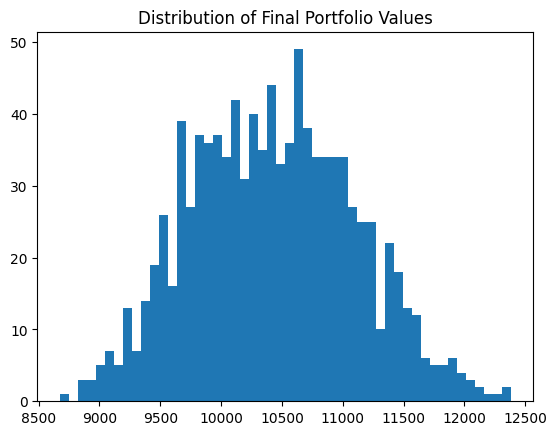

Median Wealth: $10424.6


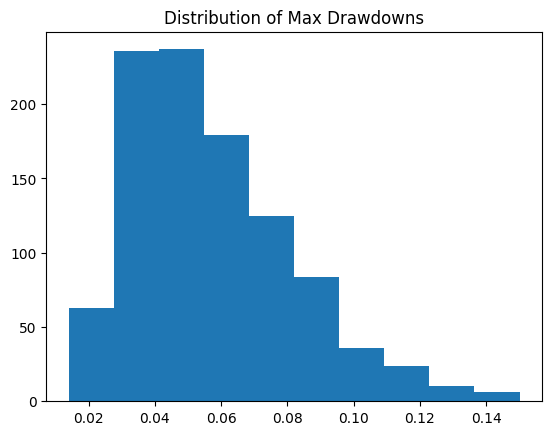

Median Max Drawdown: 5.25%
Worst Max Drawdown: 15.01%


In [73]:
port1 = CustomMonteCarlo(['SPY', 'TLT'])
port1.generate_parameters('2010-01-01', '2025-12-31')
port1.logNormMC(1000, 100, 10000, 30, [0.6,0.4], port1.corr)
port1.mcVAR(10000, port1.norm_results, 5)
port1.mcCTE(10000, port1.norm_results, 5)
port1.term_wealth(port1.norm_results)
port1.max_dd(port1.norm_portfolio_sims)

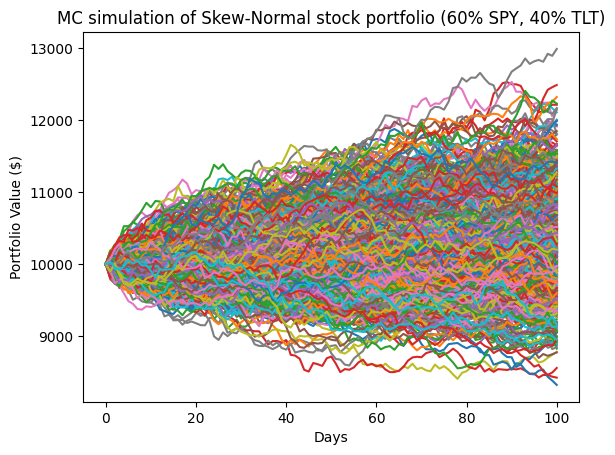

Value at Risk (95% VaR): 6.76%
Conditional Tail Expectation (95% CTE): 9.62%


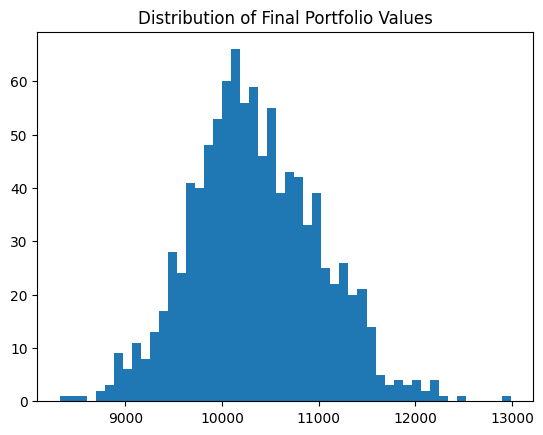

Median Wealth: $10297.96


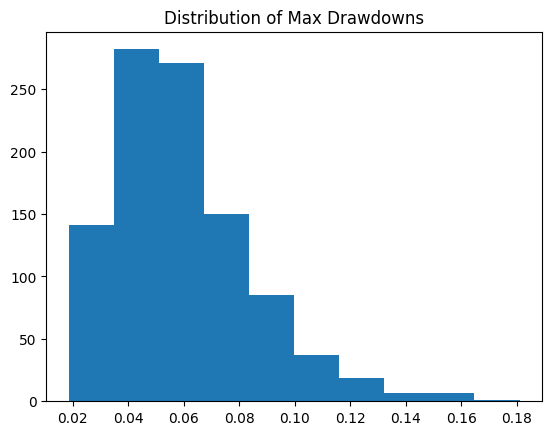

Median Max Drawdown: 5.6%
Worst Max Drawdown: 18.09%


In [75]:
port1.skewnormMC(1000, 100, 10000, 30, [0.6,0.4], port1.tau)
port1.mcVAR(10000, port1.skewnorm_results, 5)
port1.mcCTE(10000, port1.skewnorm_results, 5)
port1.term_wealth(port1.skewnorm_results)
port1.max_dd(port1.skewnorm_portfolio_sims)

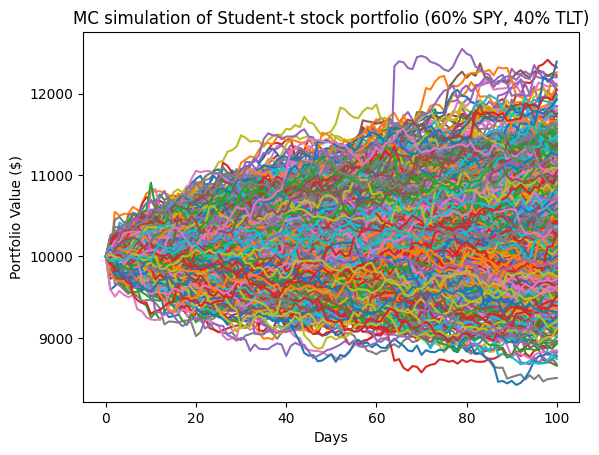

Value at Risk (95% VaR): 7.45%
Conditional Tail Expectation (95% CTE): 9.68%


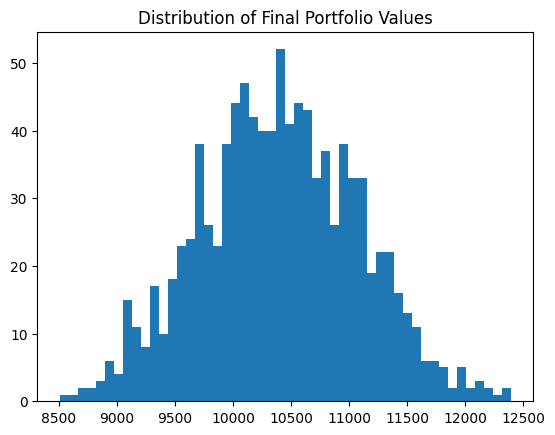

Median Wealth: $10398.04


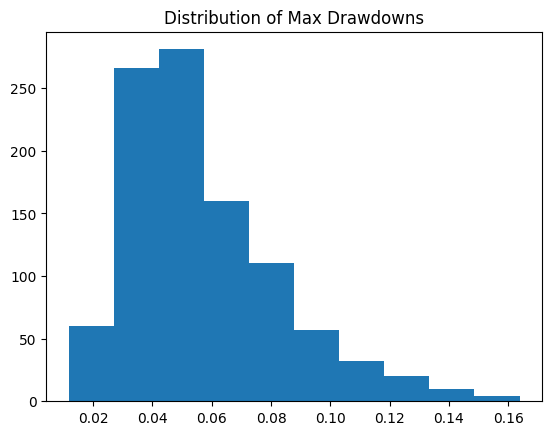

Median Max Drawdown: 5.13%
Worst Max Drawdown: 16.38%


In [83]:
port1.tDistMC(1000, 100, 10000, 30, [0.6,0.4], port1.corr, 4.5)
port1.mcVAR(10000, port1.t_results, 5)
port1.mcCTE(10000, port1.t_results, 5)
port1.term_wealth(port1.t_results)
port1.max_dd(port1.t_portfolio_sims)

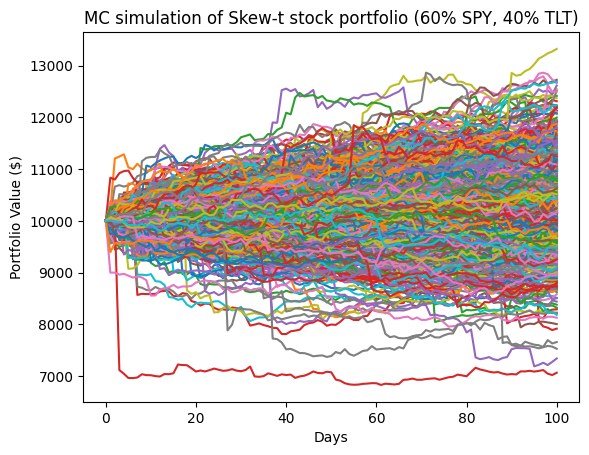

Value at Risk (95% VaR): 10.46%
Conditional Tail Expectation (95% CTE): 14.61%


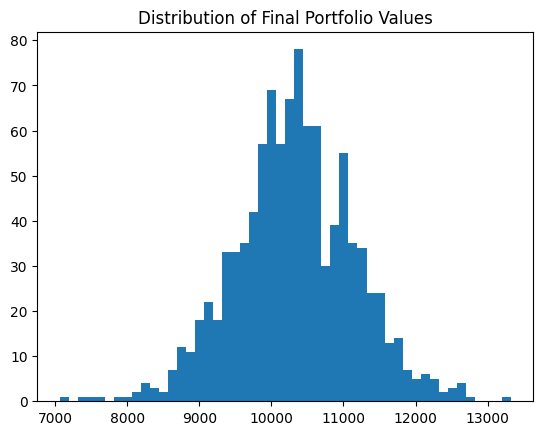

Median Wealth: $10319.39


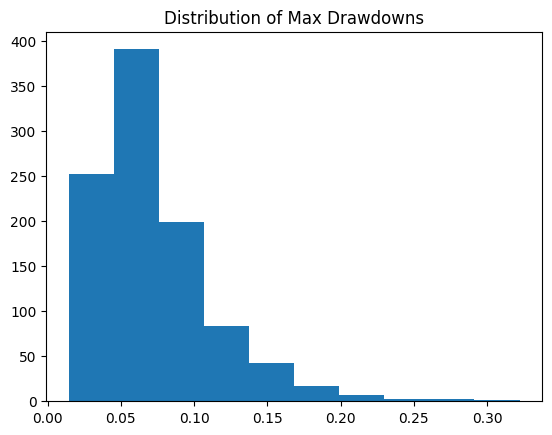

Median Max Drawdown: 6.34%
Worst Max Drawdown: 32.23%


In [91]:
port1.skewtMC(1000, 100, 10000, 30, [0.6,0.4], port1.tau, 8)
port1.mcVAR(10000, port1.skewt_results, 5)
port1.mcCTE(10000, port1.skewt_results, 5)
port1.term_wealth(port1.skewt_results)
port1.max_dd(port1.skewt_portfolio_sims)

[*********************100%***********************]  1 of 1 completed


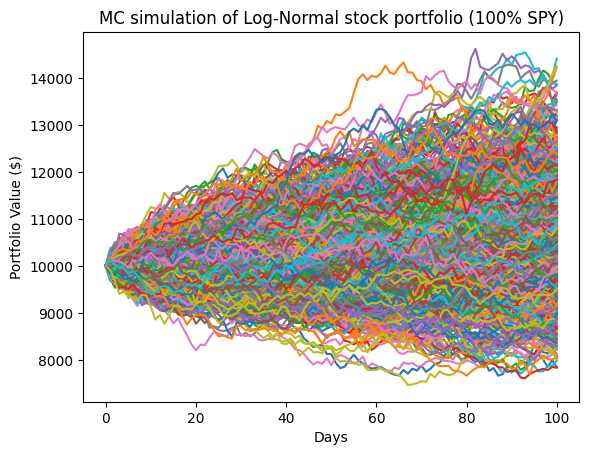

Value at Risk (95% VaR): 11.7%
Conditional Tail Expectation (95% CTE): 15.49%


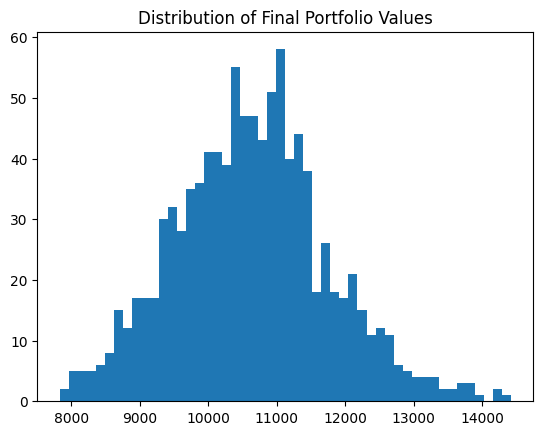

Median Wealth: $10625.42


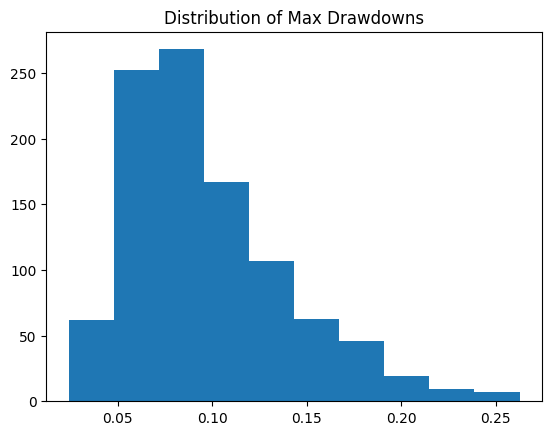

Median Max Drawdown: 8.79%
Worst Max Drawdown: 26.26%


In [93]:
portx = CustomMonteCarlo(['SPY'])
portx.generate_parameters('2010-01-01', '2025-12-31')
portx.logNormMC(1000, 100, 10000, 30, [0.6,0.4], 0.9999999) # use number very close to 1 otherwise throws error because cov matrix will not be positive definite
portx.mcVAR(10000, portx.norm_results, 5)
portx.mcCTE(10000, portx.norm_results, 5)
portx.term_wealth(portx.norm_results)
portx.max_dd(portx.norm_portfolio_sims)

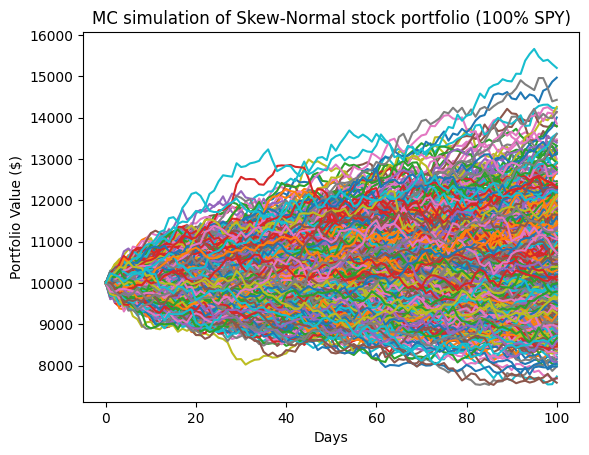

Value at Risk (95% VaR): 12.66%
Conditional Tail Expectation (95% CTE): 16.33%


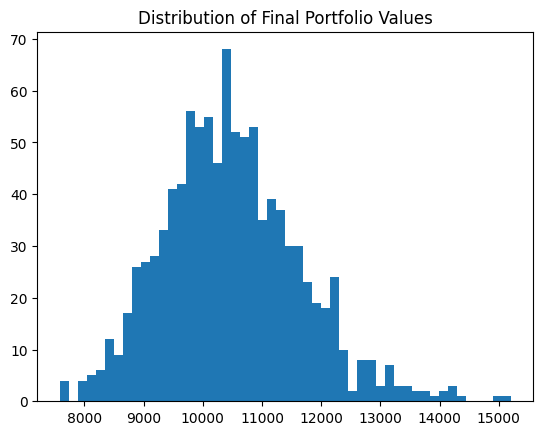

Median Wealth: $10399.78


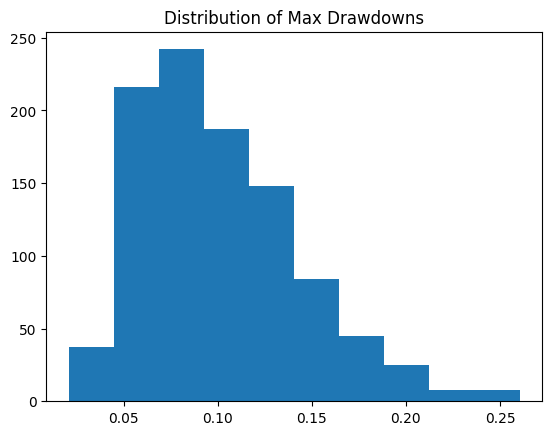

Median Max Drawdown: 9.32%
Worst Max Drawdown: 26.04%


In [95]:
portx.skewnormMC(1000, 100, 10000, 30, [0.6,0.4], portx.tau)
portx.mcVAR(10000, portx.skewnorm_results, 5)
portx.mcCTE(10000, portx.skewnorm_results, 5)
portx.term_wealth(portx.skewnorm_results)
portx.max_dd(portx.skewnorm_portfolio_sims)

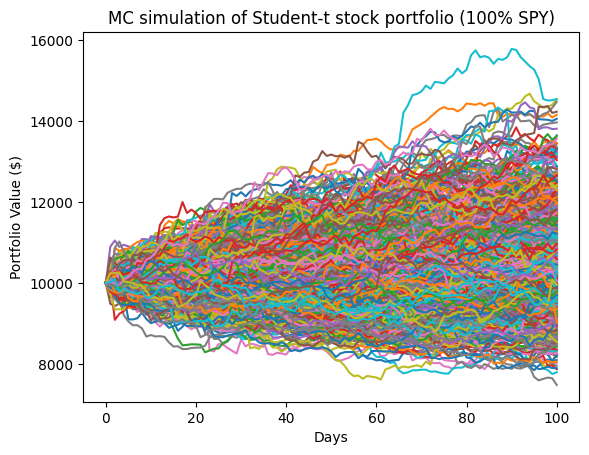

Value at Risk (95% VaR): 11.63%
Conditional Tail Expectation (95% CTE): 15.71%


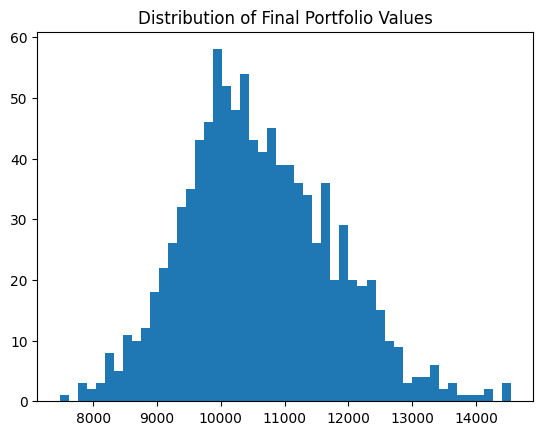

Median Wealth: $10477.15


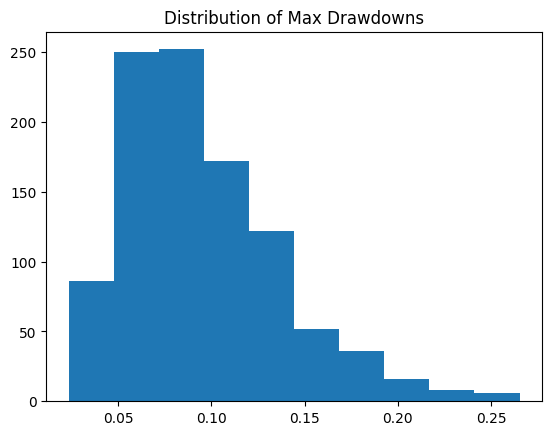

Median Max Drawdown: 8.62%
Worst Max Drawdown: 26.53%


In [97]:
portx.tDistMC(1000, 100, 10000, 30, [0.6,0.4], 0.99999, 4.5)
portx.mcVAR(10000, portx.t_results, 5)
portx.mcCTE(10000, portx.t_results, 5)
portx.term_wealth(portx.t_results)
portx.max_dd(portx.t_portfolio_sims)

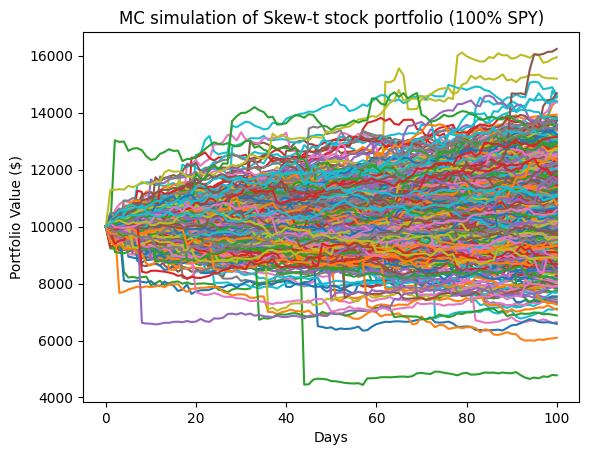

Value at Risk (95% VaR): 14.43%
Conditional Tail Expectation (95% CTE): 22.08%


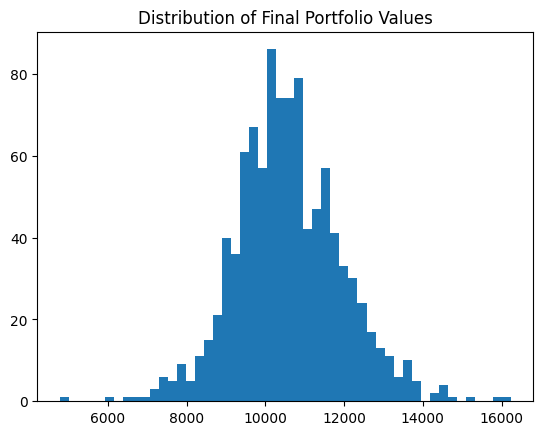

Median Wealth: $10493.07


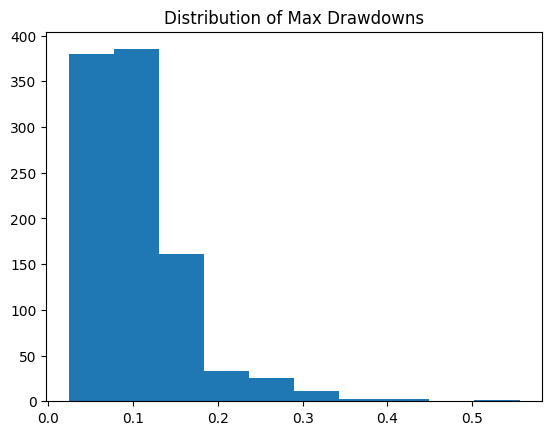

Median Max Drawdown: 9.15%
Worst Max Drawdown: 55.59%


In [103]:
portx.skewtMC(1000, 100, 10000, 30, [0.6,0.4], portx.tau, 8)
portx.mcVAR(10000, portx.skewt_results, 5)
portx.mcCTE(10000, portx.skewt_results, 5)
portx.term_wealth(portx.skewt_results)
portx.max_dd(portx.skewt_portfolio_sims)